### Deep Learning Models

시계열을 모형화하려는 노력은 과거에서부터 꾸준히 있어왔다. Box-jenkins의 시도로부터 시작하여 ARMA모형의 수많은 파생된 모형이 제작되어 왔으며, 이분산성을 고려한 조건부 이분산 모형의 계열(ARCH)도 비약적인 발전이 있었다. 이와 같은 방법론은 대부분 전통 통계 기반의 모형이며, 이 모형을 사용하기 위해서는 사용하는 데이터가 현실적으로 맞지 않는 가정들을 따라야 한다.

#### Recurrent Neural Net

Data $\mathcal{D} =:= \{x_t, y_t\}_{t=1}^N$가 시점 $t=1, \dots, N$에서 $X$와 $Y$의 자기상관성 있는 관측치인 경우 예측 문제를 sequence prediction 문제로 나타낼 수 있다. 즉 $T$ 길이의 부분 시퀀스로 구성된 고차원 입력 행렬 $X_t$를 이용해 반응$y_{t+h}$의 비선형 예측기 $\hat{y}_{t+h}$를 구축하는 문제이다.

$$\hat{y}_{t+h} = f(X_t) \text{ where } X_t := \text{seq}_{T,t}(X) = \left(x_{t-T+1}, \dots, x_t\right)$$

한편, Vanilla RNN 모형은 다음과 같이 작성할 수 있다

$$
\begin{align*}
h_t &= \sigma(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh}) \\
y_t &= W_{ho} h_t + b_o
\end{align*}
$$

여기서 다음과 같이 특수한 모양의 RNN모형을 고려한다. 1개의 hidden layer($H = 1$), activation function은 없고 입력 벡터의 차원 $P = 1$인 간단한 경우의 RNN을 고려해 보자. 추가로 $W_{z}^{(1)} = \phi_z, \vert \phi_z \vert < 1, W_x^{(1)} = \phi_x, W_y = 1, b_h = 0, b_y = \mu$를 가정하자. 그러면 $f_{W^{(1)}, b^{(1)}}^{(1)}(X_t)$가 자기회귀 계수가 기하급수적으로 감쇠하는, 즉 $\phi_i = \phi_x \phi_z^{i-1}$인 $p$차 자기회귀 $\text{AR}(p)$ 모형임을 보일 수 있다.

$$
\begin{align*}
z_{t-p} &= \phi_x x_{t-p} \\
z_{t-T+2} &= \phi_z z_{t-T+1} + \phi_x x_{t-T+2} \\
\dots &= \dots \\
z_{t-1} &= \phi_z z_{t-2} + \phi_x x_{t-1} \\
\hat{x}_t &= z_{t-1}+\mu \\
\end{align*}
$$

위 조건하에서 다음이 성립한다.

$$
\begin{align*}
\hat{x}_t &= \mu + \phi_x \left( L + \phi_z L^2 + \cdots + \phi_z^{p-1}L^p\right) \\
 &= \mu + \sum_{i=1} \phi_i x_{t-i}
\end{align*}
$$

이 특수한 경우의 자기회귀 모델 $\hat{x}_t$는 안정적이고 차수는 Durbin-watson, Ljung-Box, Box-Pierce 테스트와 같은 자기상관계수 테스트를 통해 식별 가능하다. 구조를 바꿔 순환 가중치 $W_{z,i}^{(1)} = \phi_{z,i}$가 lag dependent이라면 non-activated Hidden Layer는 다음과 같아진다.

$$z_{t-i} = \phi_{z,i} z_{t-i-1} + \phi_x x_{t-i}$$

이로부터 다음을 도출한다.

$$\hat{x}_t = \mu + \phi_x \left( L + \phi_{z,1}L^2 + \cdots + \prod_{i=1}^{p-1} \phi_{z,i}L^p\right)\left[x_t\right]$$

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TICKER = '^GSPC'
START_DATE = '2000-01-01'
END_DATE = '2024-07-18'

data = yf.download(
    TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = '1d',
    progress = False
)

In [2]:
from TimeML.torch_extension.RecurrentNeuralNet import AlphaRNN
import torch
import torch.nn as nn

prices = data['Close'].resample('W').last().pct_change().dropna().values
prices = torch.tensor(prices, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

In [3]:
sequence_length = 30
sequences = []
targets = []
for i in range(len(prices) - sequence_length):
    sequences.append(prices[i:i + sequence_length])
    targets.append(prices[i + sequence_length])

sequences = torch.stack(sequences)
targets = torch.stack(targets)

train-test split

In [4]:
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
train_targets = targets[:train_size]
test_sequences = sequences[train_size:]
test_targets = targets[train_size:]

In [5]:
input_size = 1
hidden_size = 20
num_layers = 1
model = AlphaRNN(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [6]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()
    output, hidden = model(train_sequences)
    loss = criterion(output[:, -1, -1].reshape(-1), train_targets.reshape(-1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}')

Epoch 1/20, Loss: 0.0006483470206148922
Epoch 11/20, Loss: 0.0006353564094752073


In [7]:
model.eval()
with torch.no_grad():
    test_output, test_hidden = model(test_sequences)
    test_predictions = test_output[:, -1, -1].reshape(-1)
    hidden_predictions = test_hidden[0][:, -1].reshape(-1)

In [8]:
temp = pd.Series(
    test_predictions.cpu().numpy(),
    index = data['Close'].resample('W').last().index[-250:],
    name = 'Prediction'
)

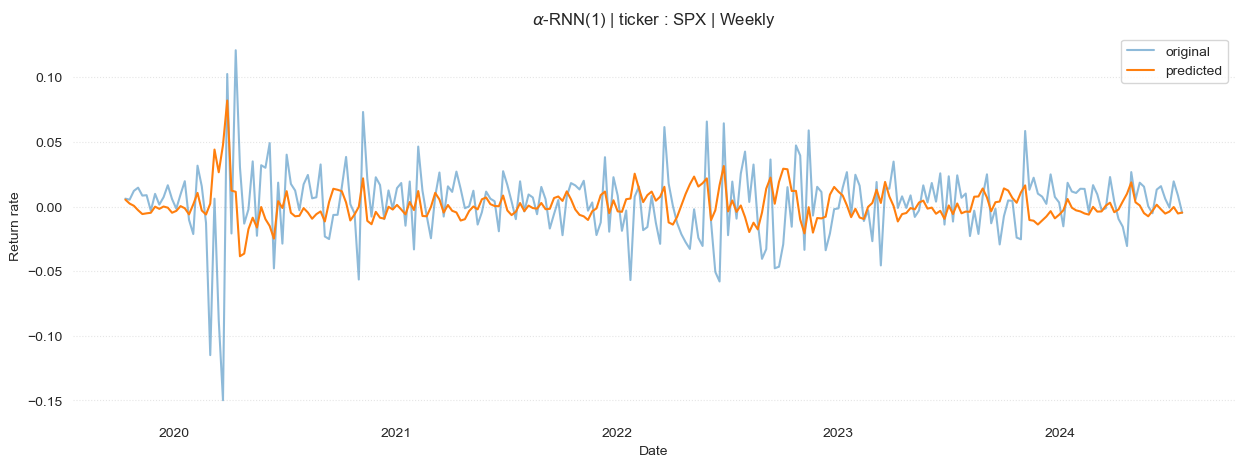

In [9]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(
    data['Close'].resample('W').last().pct_change().iloc[-250:], 
    label = 'original', 
    alpha = 0.5
)
ax.plot(temp, label = 'predicted')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'$\alpha$-RNN(1) | ticker : SPX | Weekly')
plt.xlabel('Date')
plt.ylabel('Return rate')
plt.show()

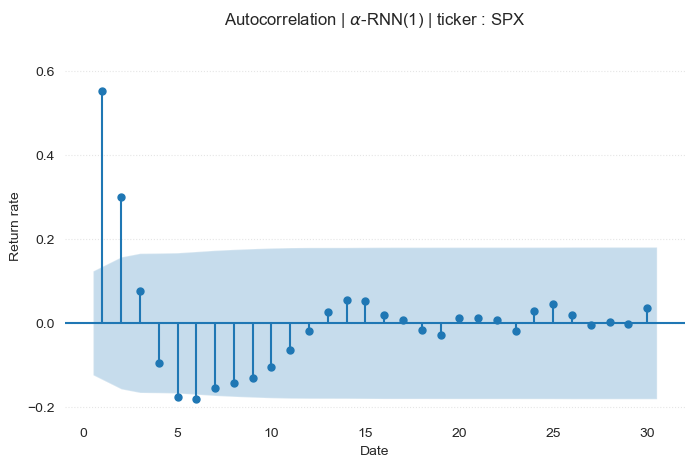

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    temp,
    lags = range(1, 31),
    auto_ylims = True, 
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Autocorrelation | $\alpha$-RNN(1) | ticker : SPX')
plt.xlabel('Date')
plt.ylabel('Return rate')
plt.show()

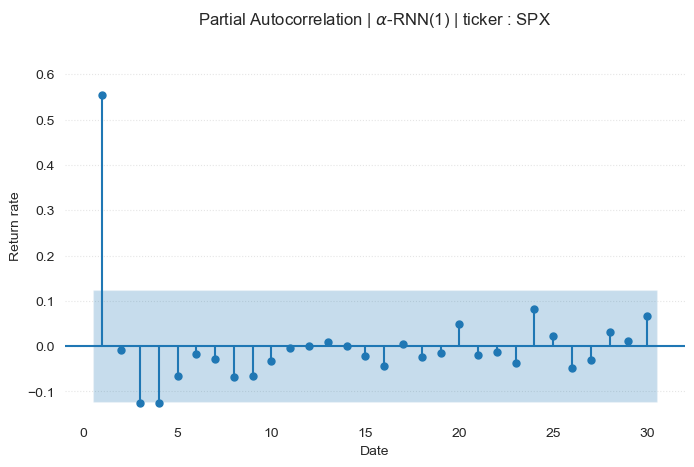

In [11]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    temp,
    lags = range(1, 31),
    auto_ylims = True, 
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title(r'Partial Autocorrelation | $\alpha$-RNN(1) | ticker : SPX')
plt.xlabel('Date')
plt.ylabel('Return rate')
plt.show()

### Dynamic $\alpha_t$ RNN

동적 지수 평활화는 평활화된 출력 $\tilde{y}_t$와 관측치 $y_t$의 시간 의존적 블록 결합이다.

$$\tilde{y}_{t+1} = \alpha_t y_t + (1 - \alpha_t)\tilde{y}_t$$

여기서 $\alpha_t \in [0,1]$은 시간에 따라 변화하는 평활화 계수를 의미하며, 이는 동일하게 1step ahead forecast 형태로 표현될 수 있다.

$$\tilde{y}_{t+1} = \tilde{y}_t + \alpha_t(y_t - \tilde{y}_t)$$

따라서 $\alpha_t$RNN은 Dynamic Forecast Error Correction Model의 일반화된 형태로 볼 수 있다. $\alpha_t = 0$인 경우 예측 오차는 무시되고, 평활화만 편재의 은닉 상태를 반복해 모델의 memory를 잃는 효과를 가진다. $\alpha_t = 1$인 경우에는 예측 오차가 현재의 은닉 상태 $\tilde{h}_t$를 완전히 대체한다.

In [16]:
from TimeML.torch_extension.RecurrentNeuralNet import AlphatRNN

In [24]:
sequence_length = 30
sequences = []
targets = []
for i in range(len(prices) - sequence_length):
    sequences.append(prices[i:i + sequence_length])
    targets.append(prices[i + sequence_length])

sequences = torch.stack(sequences)
targets = torch.stack(targets)

In [25]:
train_size = int(len(sequences) * 0.8)
train_sequences = sequences[:train_size]
train_targets = targets[:train_size]
test_sequences = sequences[train_size:]
test_targets = targets[train_size:]

In [37]:
input_size = 1
hidden_size = 100
num_layers = 1
model = AlphatRNN(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [38]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()
    output, hidden = model(train_sequences)
    loss = criterion(output[:, -1, -1].reshape(-1), train_targets.reshape(-1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item()}')

Epoch 1/20, Loss: 0.0005893191555514932
Epoch 11/20, Loss: 0.0005942157004028559


In [39]:
model.eval()
with torch.no_grad():
    test_output, test_hidden = model(test_sequences)
    test_predictions = test_output[:, -1, -1].reshape(-1)
    hidden_predictions = test_hidden[0][:, -1].reshape(-1)

In [40]:
temp = pd.Series(
    test_predictions.cpu().numpy(),
    index = data['Close'].resample('W').last().index[-250:],
    name = 'Prediction'
)

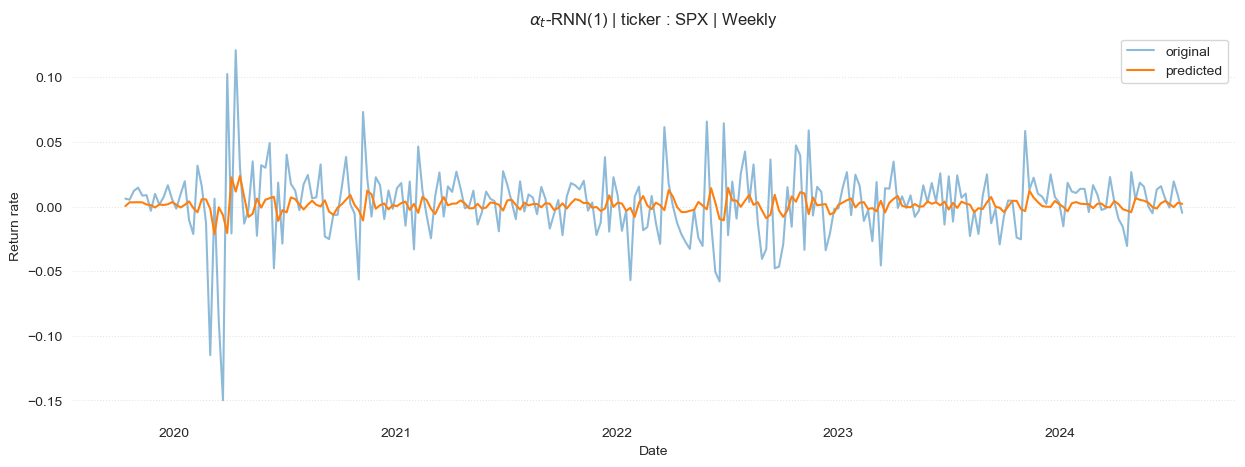

In [41]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(
    data['Close'].resample('W').last().pct_change().iloc[-250:], 
    label = 'original', 
    alpha = 0.5
)
ax.plot(temp, label = 'predicted')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'$\alpha_t$-RNN(1) | ticker : SPX | Weekly')
plt.xlabel('Date')
plt.ylabel('Return rate')
plt.show()